In [1]:
import glob
vehicleImages = glob.glob('../Data/vehicles/**/*.png')
nonVehicleImages = glob.glob('../Data/non-vehicles/**/*.png')
print('# of vehicle images -> {}'.format(len(vehicleImages)))
print('# of non-vehicle images -> {}'.format(len(nonVehicleImages)))

# of vehicle images -> 8792
# of non-vehicle images -> 8968


In [2]:
#import matplotlib.image as mpimg
import scipy.ndimage as snd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
# define all functions like in lessons -- helper functions

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    #features = cv2.resize(img, size).ravel() 
    color1 = cv2.resize(img[:,:,0],size).ravel()
    color2 = cv2.resize(img[:,:,1],size).ravel()
    color3 = cv2.resize(img[:,:,2],size).ravel()
    # concatenate the feature vector
    features = np.concatenate((color1,color2,color3))
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!--> No need as I read using scipy.ndimage.imread which has bin range from 0 to 255 included
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        #image = mpimg.imread(file)
        image = snd.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

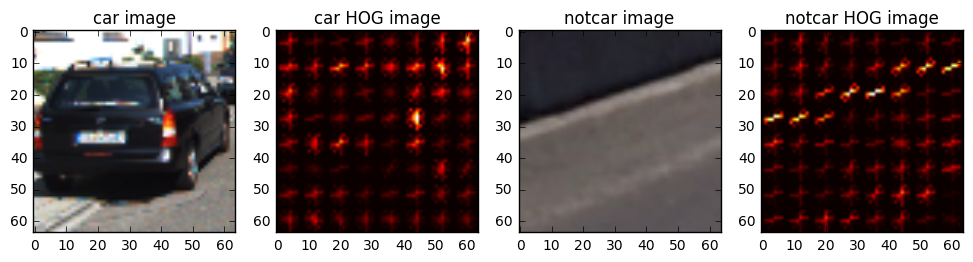

In [7]:
%matplotlib inline

# choose random car/ not-car indices
car_ind = np.random.randint(0,len(vehicleImages))
notcar_ind = np.random.randint(0,len(nonVehicleImages))

# read in car/not car image
car_image = snd.imread(vehicleImages[car_ind])
notcar_image = snd.imread(nonVehicleImages[notcar_ind])

# Define feature parameters
color_space = 'YUV'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 2 # Can be 0,1,2 or 'ALL'
spatial_size = (16,16)
hist_bins = 16
spatial_feat, hist_feat, hog_feat = True, True, True

car_features, car_hog_image = single_img_features(car_image, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, vis = True)
notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, vis = True)

images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car image', 'car HOG image', 'notcar image', 'notcar HOG image']
fig = plt.figure(figsize = (12,3))
visualize(fig,1,4,images,titles)


In [8]:
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)# Spatial binning dimensions
hist_bins = 16   # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

#y_start_stop = [400, None] # Min and max in y to search in slide_window()
t = time.time()
n_samples = 1000
random_idxs = np.random.randint(0,len(vehicleImages),n_samples)
test_cars = vehicleImages #np.array(vehicleImages)[random_idxs]
test_notcars = nonVehicleImages #np.array(nonVehicleImages)[random_idxs]

car_features = extract_features(test_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(test_notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print(time.time()-t, 'Seconds to compute features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

104.95899987220764 Seconds to compute features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
4.74 Seconds to train SVC...
Test Accuracy of SVC =  0.9932


In [4]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0 #img.shape[0]/1.5
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [5]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis = False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def visualize(fig, rows, cols, imgs, titles):
    for i,img in enumerate(imgs):
        plt.subplot(rows,cols,i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims<3:
            plt.imshow(img,cmap = 'hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

0.7309999465942383 Seconds to process 1 img search 100 windows
0.5789999961853027 Seconds to process 1 img search 100 windows
0.5350000858306885 Seconds to process 1 img search 100 windows
0.5490000247955322 Seconds to process 1 img search 100 windows
0.5230000019073486 Seconds to process 1 img search 100 windows
0.5130000114440918 Seconds to process 1 img search 100 windows


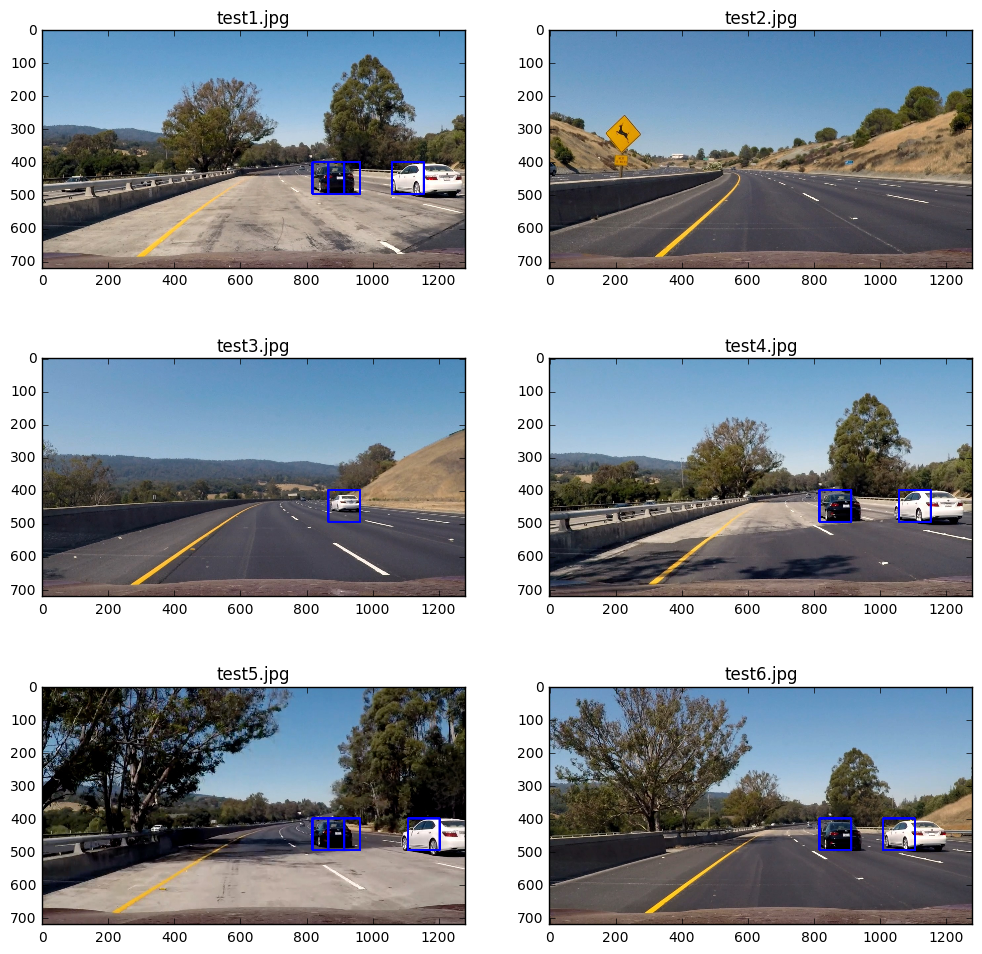

In [9]:
%matplotlib inline
test_images = glob.glob('./test_images/*.jpg')
images, titles = [], []
y_start_stop = [400, 656] # Min, Max search in slide_window()
overlap = 0.5
for img_src in test_images:
    t1 = time.time()
    img = snd.imread(img_src)
    draw_img = np.copy(img)
    
    #windows1 = slide_window(img, x_start_stop = [None, None], y_start_stop = y_start_stop,
    #                      xy_window = (128,128), xy_overlap = (overlap,overlap))
    windows = slide_window(img, x_start_stop = [None, None], y_start_stop = y_start_stop,
                          xy_window = (96,96), xy_overlap = (overlap,overlap))
    #windows = windows1 + windows2
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space = color_space,
                                 spatial_size = spatial_size, hist_bins = hist_bins,
                                 orient = orient, pix_per_cell = pix_per_cell,
                                 cell_per_block = cell_per_block,
                                 hog_channel = hog_channel, spatial_feat = spatial_feat,
                                 hist_feat = hist_feat, hog_feat = hog_feat)
    window_img = draw_boxes(draw_img, hot_windows, color = (0,0,255), thick = 6)
    images.append(window_img)
    titles.append(img_src[-9:])
    print(time.time()-t1, 'Seconds to process 1 img search', len(windows), 'windows')

fig = plt.figure(figsize = (12,12), dpi = 300)
visualize(fig, 3,2, images, titles)

In [10]:
# Rather than extracting hog features for each 96x96 window, 
# take the hog feature of whole image and then take sub-sample the array
# to extract features of each window
def convert_color(img, conv = 'RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)
    elif conv == 'RGB2LUV':
        return cv2.cvtColor(img,cv2.COLOR_RGB2LUV)

def find_cars(img, scale=1):
    draw_img = np.copy(img)
    # make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv = 'RGB2LUV')
    # resize whole search image instead of resize window size
    if scale !=1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1, ch2, ch3 = ctrans_tosearch[:,:,0], ctrans_tosearch[:,:,1], ctrans_tosearch[:,:,2] 
    
    # compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    # Define blocks and steps
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblocks_per_window = (window //pix_per_cell) - 1
    
    cells_per_step = 2 # Instead of overlap define how many cells to step ~75% overlap
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract hog for only this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop  = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size = spatial_size)
            hist_features = color_hist(subimg, nbins = hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw, ytop_draw+win_draw+ystart),(0,0,255),6)
                #img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] +=1
                
    return draw_img, heatmap

In [11]:
from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    # zero below threshold
    heatmap[heatmap<=threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate thru all detected cars
    bbox_topleft = []
    bbox_bottomright = []
    for iCar in range(1, labels[1]+1):
        # find pixels with each car number label value
        nonzero = (labels[0] == iCar).nonzero()
        # identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        #define a bounding box based on min/max x and y
        bbox_topleft.append((np.min(nonzerox), np.min(nonzeroy)))
        bbox_bottomright.append((np.max(nonzerox),np.max(nonzeroy)))
        # draw box on the image only one rectangle at a time
        cv2.rectangle(img, (bbox_topleft[iCar-1]), (bbox_bottomright[iCar-1]), (0,0,255),6)
        
    return img, bbox_topleft, bbox_bottomright
    

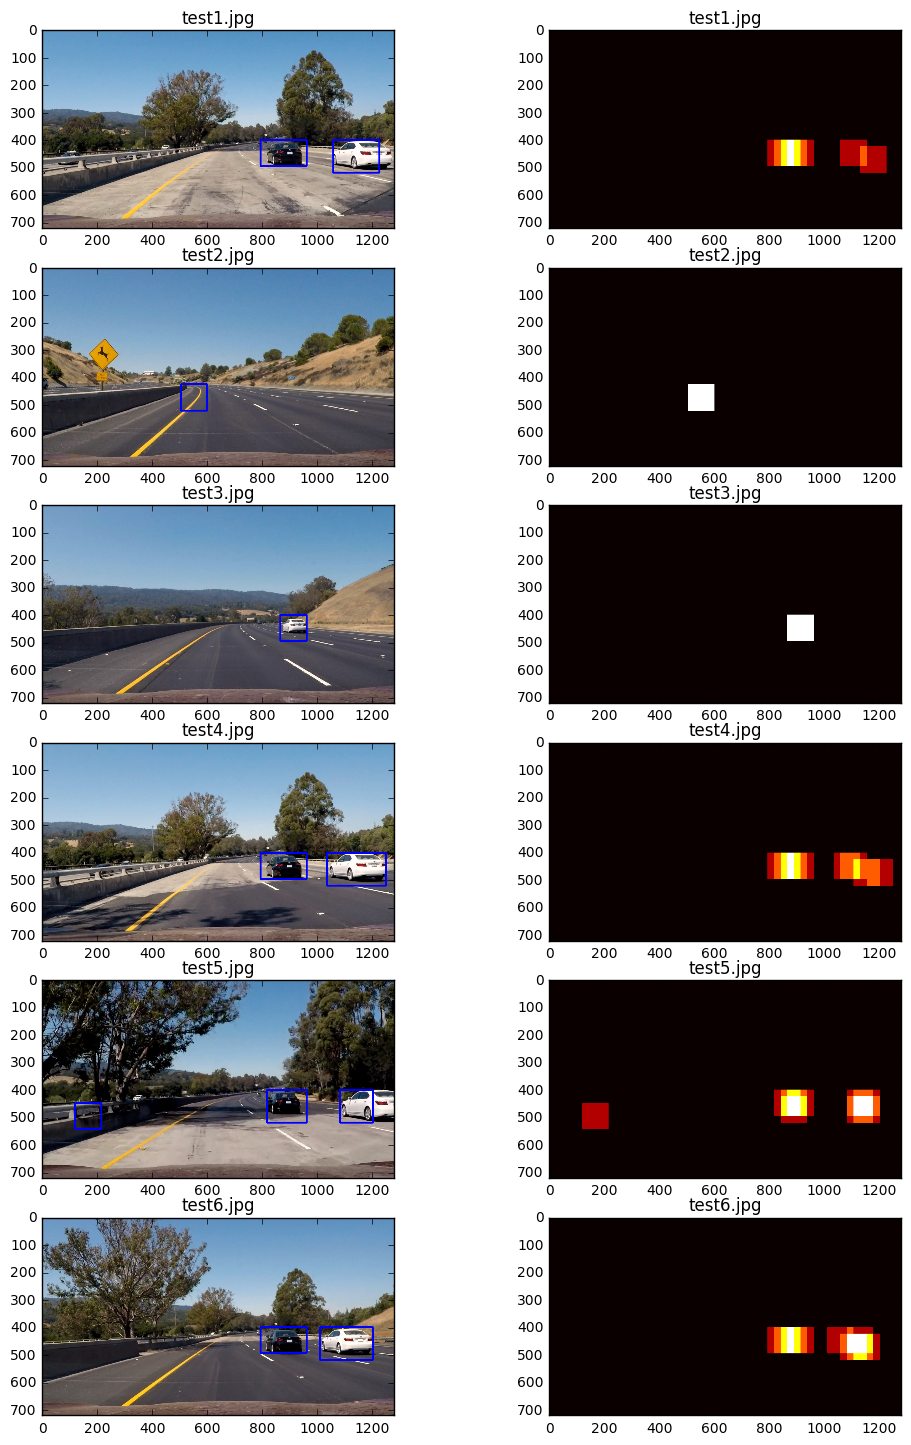

In [12]:
out_images = []
out_titles = []
ystart, ystop, scale = 400, 656, 1.5
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)# Spatial binning dimensions
hist_bins = 16   # Number of histogram bins
# Iterate over test images
for img_src in test_images:
    img = snd.imread(img_src)
    out_img, heat_map = find_cars(img, scale)
    # Don't really think we need this
    #heat_map = apply_threshold(heat_map,1)
    labels = label(heat_map)
    # Draw bounding boxes on a copy of image
    draw_img,_,temp = draw_labeled_bboxes(np.copy(img), labels)
    out_images.append(draw_img)
    out_titles.append(img_src[-9:])
    out_images.append(heat_map)
    out_titles.append(img_src[-9:])
    #print(temp)
fig = plt.figure(figsize = (12,24))
visualize(fig, 8, 2, out_images, out_titles)

In [13]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def process_image(img):
    
    out_img, heat_map = find_cars(img,scale)
    heat_map = apply_threshold(heat_map,1)
    labels = label(heat_map)
    draw_img,_,_ = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [ ]:
test_output = 'ptest.mp4'
clip = VideoFileClip('project_video.mp4')
test_clip = clip.fl_image(process_image)
test_clip.write_videofile(test_output, audio = False)

In [ ]:
HTML("""
<video width = "960" height="540" controls>
  <source src="{0}">
""".format(test_output))

In [23]:
import collections
#from itertools import chain, repeat
from functools import reduce

def bbox_overlap(car_topleft,car_bottomright, bbox_topleft, bbox_bottomright):
    x1, y1 = car_topleft 
    x2, y2 = car_bottomright
    x3, y3 = bbox_topleft
    x4, y4 = bbox_bottomright
    
    # new bounding box area
    area = (x4 - x3 + 1) * (y4 - y3 + 1)
    
    xx1 = np.maximum(x1, x3)
    yy1 = np.maximum(y1, y3)
    xx2 = np.minimum(x2, x4)
    yy2 = np.minimum(y2, y4)

    # compute the width and height of the combined bounding box
    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)

    # compute the ratio of overlap combined vs new bounding box
    overlap = (w * h) / area
    return overlap


# define a class to receive vehicle characteristics when detected
class Vehicle():
    def __init__(self, cache_length=10):
        self.detected = False # was vehicle detected in last iteration?
        self.n_detections = 0 # # of times this vehicle has been detected?
        self.n_nondetections = 0 # of cons. times this car not detected
        self.topleft = None # Top left x,y values of last detection
        self.bottomright = None # Bottom right x,y values of last detection
        # top left and right values of the last n fits of the line
        self.recent_topleft = collections.deque(maxlen = cache_length) # bbox x position of last n fits
        self.recent_bottomright = collections.deque(maxlen = cache_length) # bbox y position of last n fits
        # avg of all recent values - if not detected take this value or last detection ... not sure yet
        self.best_topleft = None # avg x pos of last n fits
        self.best_bottomright = None # avg y pos of last n fits
        # get centroid to find next image contains this car or not
        self.centroid = None
        
    def add_measurement(self,bbox_topleft, bbox_bottomright):
        # Use all pixels from previous detections for curve fit
        weights = np.ones(len(self.recent_topleft))
        if len(weights) > 1:
            weights[0] = 0.8
            weights[1:] = 0.2/(len(weights) - 1)
            #print(weights, self.recent_topleft)
            # kind of sum(weighs*values), a is kind of first iteration and b[0] i.e. w, b[1] i.e. bbox are (w*bbox)
            w_topleft = reduce(lambda a,b: a + b[0]*b[1], zip(np.vstack((weights,weights)).T, self.recent_topleft), np.zeros(2))
            w_bottomright = reduce(lambda a,b: a + b[0]*b[1], zip(np.vstack((weights,weights)).T, self.recent_bottomright), np.zeros(2))
        else: # no previous data
            w_topleft, w_bottomright = bbox_topleft, bbox_bottomright
        
        self.topleft, self.bottomright = bbox_topleft, bbox_bottomright
        self.recent_topleft.append(tuple(bbox_topleft))
        self.recent_bottomright.append(tuple(bbox_bottomright))
        #
        # issue with below 4 lines of code as it was giving quite slow update on draw image
        #self.recent_topleft.append(tuple(w_topleft))
        #self.recent_bottomright.append(tuple(w_bottomright))
        #self.best_topleft = np.int32(np.round(np.mean(self.recent_topleft,axis = 0))) # to draw
        #self.best_bottomright = np.int32(np.round(np.mean(self.recent_bottomright, axis = 0))) # to draw
        #
        self.best_topleft = np.int32(np.round(w_topleft)) # to draw
        self.best_bottomright = np.int32(np.round(w_bottomright)) # to draw
        self.centroid = np.mean((self.best_topleft,self.best_bottomright), axis = 0)
        self.detected = True
        self.n_detections +=1
            
    def draw_image_with_cars(self,image,cnum):
        draw_img = np.copy(image)
        cv2.rectangle(draw_img, tuple(self.best_topleft), tuple(self.best_bottomright), (0,0,255),6)
        text_loc = tuple((self.best_topleft[0],self.best_topleft[1]-20))
        cv2.putText(draw_img, 'Car # {}'.format(cnum), text_loc ,fontFace = 16, fontScale = 0.5, color=(255,255,255), thickness = 2)
        return draw_img

In [20]:
# define all parameters

# process image
dist_threshold = 100
overlap_threshold = 0.05
max_age = 2 # for # of non_detections to remove old detections
min_age = 5 # for # of detections to display, to remove false positives
carslist = []
hm_threshold = 1
# scaling
ystart, ystop, scale = 400, 656, 1.5 # Min, Max search in slide_window()
# feature algorithm
#overlap = 0.5, find cars algorithm does'nt need it
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)# Spatial binning dimensions
hist_bins = 16   # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
temp = [] # temporary variable to save some outputs for debugging

# pipeline for processing of the video
def process_image(img):
    
    #initialize to remove any long time non detected cars
    detected_cars = []
    nondetected_cars = []
    i_remove = []
    
    #find cars using the svc learned feature extraction
    _, heat_map = find_cars(np.copy(img),scale)
    
    #reduce the box size to potentially similar to vehicle size by giving threshold to heatmap
    heat_map = apply_threshold(heat_map,hm_threshold)
    
    # convert the heat map into labels (in this case individual cars), 
    # >0 with surrounded >0 values is then combined into one box i.e. identified car
    labels = label(heat_map)
    
    #get all found bounding boxes for current image, not necessary to use that image
    _, bbox_topleft, bbox_bottomright = draw_labeled_bboxes(np.copy(img), labels)
    
    # add new found vehicles or append measurement for old vehicles
    if bbox_topleft != [] or bbox_bottomright != []:
    # magic about using class to identify which is car 1,2 and appending the last indices and smooth output
        if carslist == []: # only for first time a vehicle (i.e. a bounding box) is found in the frame
            for iCar in range(0, len(bbox_topleft)):
                #print('add')
                carslist.append(Vehicle()) # first time a car is detected in video or after long time of no cars detection
                carslist[iCar].add_measurement(bbox_topleft[iCar],bbox_bottomright[iCar])
        else:# do loads of finding index of car and search nearby for same car and if not found then append to car list
            for iCentroid in range(0, len(bbox_topleft)):
                detected_cars = [] # remaining cars get nondetection penalty points ;)
                current_centroid = np.mean((bbox_topleft[iCentroid],bbox_bottomright[iCentroid]), axis = 0)
                # already there are certain cars in last few video frames
                dist, olap = [], []
                for iCar in range(0,len(carslist)):
                    #print('CC is {} and carlist CC is {}'.format(current_centroid, carslist[iCar].centroid))
                    dist.append(np.linalg.norm((carslist[iCar].centroid - current_centroid))) # euclidean distance
                    olap.append(bbox_overlap(carslist[iCar].best_topleft,carslist[iCar].best_bottomright, bbox_topleft[iCentroid], bbox_bottomright[iCentroid])) 
                # index for nearest previous threshold
                nearest_car_idx = np.argmin(dist)
                # index for maximum overlap
                maxo_car_idx = np.argmax(olap)
                temp.append((nearest_car_idx, maxo_car_idx, dist, olap))
                if dist[nearest_car_idx] > dist_threshold and olap[maxo_car_idx] < overlap_threshold: 
                    carslist.append(Vehicle()) # new car detected
                    carslist[-1].add_measurement(bbox_topleft[iCentroid], bbox_bottomright[iCentroid])
                elif olap[maxo_car_idx] >= overlap_threshold:
                    detected_cars.append(maxo_car_idx)
                    carslist[maxo_car_idx].add_measurement(bbox_topleft[iCentroid], bbox_bottomright[iCentroid])
                else:
                    detected_cars.append(nearest_car_idx)
                    carslist[nearest_car_idx].add_measurement(bbox_topleft[iCentroid], bbox_bottomright[iCentroid])

    elif len(carslist)>0:
        for iCar in range(len(carslist)):
            carslist[iCar].n_nondetections +=1
            carslist[iCar].detected = False
    
    # give penalty to non-detected cars in this frame of video
    if detected_cars != []:
        nondetected_cars = np.setxor1d(np.unique(detected_cars),np.arange(len(carslist)),assume_unique = True)
        if nondetected_cars != []: 
            for inon in nondetected_cars:
                carslist[inon].n_nondetections +=1
                carslist[inon].detected = False
    
    # remove cars in reverse order from carslist if not detected since last 'max_age' frames of video
    i_remove = [iCar for iCar in range(len(carslist)) if carslist[iCar].n_nondetections >= max_age] # cars to remove in sorted order
    if i_remove != []:
        i_remove = i_remove[::-1] # descending order
        for ir in i_remove:
            carslist.pop(ir)
    
    # all carslist is ready either empty or with some found cars to be displayed
    if len(carslist)>0:
        draw_img = np.copy(img)
        for iCar in range(len(carslist)):
            if carslist[iCar].n_detections >= min_age:
                draw_img = carslist[iCar].draw_image_with_cars(draw_img,iCar+1)
    else:
        draw_img = np.copy(img)
    
    return draw_img


def clear_cache():
    process_image.cache = None

In [21]:
clear_cache()
test_output = 'ptest_filtered.mp4'
#clip = VideoFileClip('project_video.mp4').subclip(45)
clip = VideoFileClip('project_video.mp4')
test_clip = clip.fl_image(process_image)
test_clip.write_videofile(test_output, audio = False)

[MoviePy] >>>> Building video ptest_filtered.mp4
[MoviePy] Writing video ptest_filtered.mp4


100%|█████████▉| 1260/1261 [08:12<00:00,  2.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ptest_filtered.mp4 



In [22]:
HTML("""
<video width = "960" height="540" controls>
  <source src="{0}">
""".format(test_output))

In [ ]:
# only used for debugging
temp